# Home Cage Elo Score Calculation

In [1]:
import re
import os
import sys
from collections import defaultdict
import glob
import warnings

In [2]:
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import xlrd

In [4]:
# setting path
sys.path.append('../../src')

In [5]:
from eloscore import eloscore

In [6]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

## Summary

- Experiment
    - Observing fighting behavior between mice in their home cage in different settings. Mice are categorized as winner and loser based on if they initiated the behavior or if they are recieving it. Recording sessions are usually from 30 minutes to a hour with cages of 2 to 6 mice.
- Data
    - Excel spreadsheet of recorded fighting behavior. The relevant columns are those of the "Date" of the recording, the "winner" of the interaction, and the "loser" of the interaction. Each row will be for one interaction between two mice.
    - There is a cage for each sheet of the spreadsheet
    - For each recording session, we will assume that the date will be specified for that first row. We will use this to seperate all the rows into seperate sessions.
- Purpose of this Jupyter Notebook
    - To calculate the Elo Score of each mice after each interaction. The mice start off with an Elo score of 1000. Elo scores are calculated with the formula from here: https://www.omnicalculator.com/sports/elo . Then we will plot the change of elo score across all interactions. With the number of interactions on the X-Axis and the current Elo score on the Y. There will be a line for mice.

## Getting the file name

- Searching for files that are in the `./data` folder (in the folder that this notebook is in) that have `home` in the file name

In [7]:
input_folder = "./data"

In [8]:
raw_data_file_keyword = '*[hH]ome*'

In [9]:
# Searching for matching files with recursion
if glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword)):
    raw_data_files_list = glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword))
# Searching for matching files only in the folder
elif glob.glob(os.path.join(input_folder, raw_data_file_keyword)):
    raw_data_files_list = glob.glob(os.path.join(input_folder, raw_data_file_keyword))
else:
    raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))

In [10]:
raw_data_files_list

['./data/Homecage_observations.xlsx']

In [11]:
raw_data_file_path = raw_data_files_list[0]

In [12]:
raw_data_file_path

'./data/Homecage_observations.xlsx'

## Importing Data for One Sheet

- The original data has been trimmed so that only the cells with dates, winner ID's, and relevant metadata were kept

In [13]:
xls = pd.ExcelFile(raw_data_file_path)
sheets = xls.sheet_names

In [14]:
sheets

['cage 3-4', 'CAGE3', 'CAGE4', 'Master List']

In [15]:
home_cage_observations_df = pd.read_excel(raw_data_file_path, sheet_name=sheets[1], header=0)

In [16]:
home_cage_observations_df.head()

,Oberserver,Notes,Length of Observation,Date,Cage #,Winner,Loser,Action,1,2,3,4
0,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,4,c,1.0,NaN,NaN,-1.0
1,NaN,NaN,NaN,NaT,NaN,1,4,f,1.0,NaN,NaN,-1.0
2,NaN,NaN,NaN,NaT,NaN,1,2,f,1.0,-1.0,NaN,NaN
3,NaN,NaN,NaN,NaT,NaN,1,4,f,1.0,NaN,NaN,-1.0
4,NaN,NaN,NaN,NaT,NaN,1,2,f,1.0,-1.0,NaN,NaN


## Standarizing the Column

In [17]:
original_column_name_to_standarized = defaultdict(dict)
for col in home_cage_observations_df.columns:
    original_column_name_to_standarized[col] = str(col).lower().strip()

In [18]:
original_column_name_to_standarized

defaultdict(dict,
            {'Oberserver': 'oberserver',
             'Notes': 'notes',
             'Length of Observation': 'length of observation',
             'Date': 'date',
             'Cage #': 'cage #',
             'Winner': 'winner',
             'Loser': 'loser',
             'Action': 'action',
             1: '1',
             2: '2',
             3: '3',
             4: '4'})

In [19]:
home_cage_observations_df = home_cage_observations_df.rename(columns=original_column_name_to_standarized)

In [20]:
home_cage_observations_df

,oberserver,notes,length of observation,date,cage #,winner,loser,action,1,2,3,4
0,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,4,c,1.0,NaN,NaN,-1.0
1,NaN,NaN,NaN,NaT,NaN,1,4,f,1.0,NaN,NaN,-1.0
2,NaN,NaN,NaN,NaT,NaN,1,2,f,1.0,-1.0,NaN,NaN
3,NaN,NaN,NaN,NaT,NaN,1,4,f,1.0,NaN,NaN,-1.0
4,NaN,NaN,NaN,NaT,NaN,1,2,f,1.0,-1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
60,NaN,NaN,NaN,NaT,NaN,1,2,f,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaT,NaN,1,4,f,NaN,NaN,NaN,NaN
62,NaN,NaN,NaN,NaT,NaN,1,4,c,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaT,NaN,3,4,g,NaN,NaN,NaN,NaN


## Adding the session number

- Each new session has the date as a row, so we will get the index of all the rows with dates

In [21]:
home_cage_observations_df.dropna(axis=0, subset="date")

,oberserver,notes,length of observation,date,cage #,winner,loser,action,1,2,3,4
0,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,4,c,1.0,NaN,NaN,-1.0
26,Naeliz,"right after tubetesting, and without dominant ...",NaN,2022-05-05,3.0,4,3,f,NaN,NaN,NaN,NaN
34,Naeliz,"right after tubetesting, and without dominant ...",NaN,2022-05-06,3.0,2,3,g,NaN,NaN,NaN,NaN
39,Naeliz,"powervacuum in cage 3, wasnt able to reintrodu...",NaN,2022-05-11,3.0,3,4,c,NaN,NaN,NaN,NaN
51,Naeliz,homecage observation in their regular homecage...,NaN,2022-05-13,3.0,1,4,f,NaN,NaN,NaN,NaN


- Getting the indexes of where each new session starts

In [22]:
home_cage_observations_df.dropna(axis=0, subset="date").index

Int64Index([0, 26, 34, 39, 51], dtype='int64')

In [23]:
session_indexes = home_cage_observations_df.dropna(axis=0, subset="date").index

- Adding a column for the session number and then filling all the `NaNs`

In [24]:
home_cage_observations_df = eloscore.add_session_number_column(home_cage_observations_df, session_indexes)
home_cage_observations_df = home_cage_observations_df.fillna(method='ffill')

- Making another column for plotting

In [25]:
home_cage_observations_df = eloscore.add_session_number_column(home_cage_observations_df, session_indexes, session_number_column="session_number_plotting")

In [26]:
home_cage_observations_df.head()

,oberserver,notes,length of observation,date,cage #,winner,loser,action,1,2,3,4,session_number,session_number_plotting
0,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,4,c,1.0,NaN,NaN,-1.0,1.0,1.0
1,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,4,f,1.0,NaN,NaN,-1.0,1.0,NaN
2,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,2,f,1.0,-1.0,NaN,-1.0,1.0,NaN
3,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,4,f,1.0,-1.0,NaN,-1.0,1.0,NaN
4,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,2,f,1.0,-1.0,NaN,-1.0,1.0,NaN


## Dropping the rows with only Chase and Fights

In [27]:
home_cage_observations_df["action"].unique()

array(['c', 'f', 'g', 'groom (g)'], dtype=object)

In [28]:
home_cage_observations_df = home_cage_observations_df[home_cage_observations_df["action"].isin(["f", "c"])]

In [29]:
home_cage_observations_df

,oberserver,notes,length of observation,date,cage #,winner,loser,action,1,2,3,4,session_number,session_number_plotting
0,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,4,c,1.0,NaN,NaN,-1.0,1.0,1.0
1,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,4,f,1.0,NaN,NaN,-1.0,1.0,NaN
2,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,2,f,1.0,-1.0,NaN,-1.0,1.0,NaN
3,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,4,f,1.0,-1.0,NaN,-1.0,1.0,NaN
4,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,2,f,1.0,-1.0,NaN,-1.0,1.0,NaN
5,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,2,f,1.0,-1.0,NaN,-1.0,1.0,NaN
7,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,2,f,1.0,-1.0,NaN,-1.0,1.0,NaN
8,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,2,f,1.0,-1.0,NaN,-1.0,1.0,NaN
9,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,2,f,1.0,-1.0,NaN,-1.0,1.0,NaN
10,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,4,f,1.0,-1.0,NaN,-1.0,1.0,NaN


In [30]:
home_cage_observations_df.shape

(45, 14)

## Calculating ELO Score

- Example calculation

In [31]:
eloscore.calculate_elo_score(subject_elo_score=1000, agent_elo_score=2000)

1020

## Get the Elo score for all the events

In [32]:
home_cage_observations_df.head()

,oberserver,notes,length of observation,date,cage #,winner,loser,action,1,2,3,4,session_number,session_number_plotting
0,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,4,c,1.0,NaN,NaN,-1.0,1.0,1.0
1,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,4,f,1.0,NaN,NaN,-1.0,1.0,NaN
2,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,2,f,1.0,-1.0,NaN,-1.0,1.0,NaN
3,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,4,f,1.0,-1.0,NaN,-1.0,1.0,NaN
4,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,2,f,1.0,-1.0,NaN,-1.0,1.0,NaN


In [33]:
eloscore.update_elo_score(winner_id="A", loser_id="B")

defaultdict(<function eloscore.eloscore.update_elo_score.<locals>.<lambda>()>,
            {'A': 1010.0, 'B': 990.0})

- Function that creates a dictionary that has the original/updated elo score for each event

In [34]:
index_to_elo_score_and_meta_data = eloscore.iterate_elo_score_calculation_for_data_frame(data_frame=home_cage_observations_df, winner_column="winner", loser_column="loser", additional_columns=["date", "session_number", "session_number_plotting"])

In [35]:
index_to_elo_score_and_meta_data[0]

{'total_match_number': 1,
 'subject_id': 1,
 'agent_id': 4,
 'original_elo_score': 1000,
 'updated_elo_score': 1010.0,
 'win_draw_loss': 1,
 'date': Timestamp('2022-05-04 00:00:00'),
 'session_number': 1.0,
 'session_number_plotting': 1.0}

- Turning the dictionary into a dataframe

In [36]:
home_cage_elo_score_df = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

In [37]:
home_cage_elo_score_df.head()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number,session_number_plotting
0,1,1,4,1000.0,1010.0,1,2022-05-04,1.0,1.0
1,1,4,4,1000.0,990.0,1,2022-05-04,1.0,1.0
2,2,1,4,1010.0,1019.4,1,2022-05-04,1.0,NaN
3,2,4,4,990.0,980.6,1,2022-05-04,1.0,NaN
4,3,1,2,1019.4,1028.8,1,2022-05-04,1.0,NaN


In [38]:
home_cage_elo_score_df.tail()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number,session_number_plotting
85,43,2,2,892.9,889.6,1,2022-05-13,5.0,NaN
86,44,1,4,1176.5,1180.8,1,2022-05-13,5.0,NaN
87,44,4,4,953.2,948.9,1,2022-05-13,5.0,NaN
88,45,1,4,1180.8,1185.0,1,2022-05-13,5.0,NaN
89,45,4,4,948.9,944.7,1,2022-05-13,5.0,NaN


In [39]:
home_cage_elo_score_df.groupby("subject_id").count()

,total_match_number,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number,session_number_plotting
subject_id,,,,,,,,
1,31,31,31,31,31,31,31,2
2,25,25,25,25,25,25,25,0
3,13,13,13,13,13,13,13,2
4,21,21,21,21,21,21,21,4


In [40]:
home_cage_elo_score_df.groupby("session_number").count()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number_plotting
session_number,,,,,,,,
1.0,38,38,38,38,38,38,38,2
2.0,6,6,6,6,6,6,6,2
4.0,22,22,22,22,22,22,22,2
5.0,24,24,24,24,24,24,24,2


# Plotting the Elo Score by match number

In [41]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

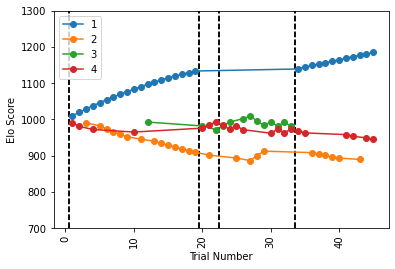

In [42]:
fig, ax = plt.subplots()

# Drawing vertical lines that represent when each session begins
for index, row in home_cage_elo_score_df.dropna(subset=["session_number_plotting"]).iterrows():
    # Offsetting by 0.5 to avoid drawing the line on the dot
    plt.vlines(x=[row["total_match_number"] - 0.5], ymin=700, ymax=1300, colors='black', linestyle='dashed')

# Drawing a line for each subject
for subject in sorted(home_cage_elo_score_df["subject_id"].unique()):
    # Getting all the rows with the current subject
    subject_df = home_cage_elo_score_df[home_cage_elo_score_df["subject_id"] == subject]
    # Making the dates into days after the first session by subtracting all the dates by the first date
    plt.plot(subject_df["total_match_number"], subject_df["updated_elo_score"], '-o', label=subject)

# Labeling the X/Y Axis and the title
ax.set_xlabel("Trial Number")
ax.set_ylabel("Elo Score")
# ax.set_title("Elo Score for Home Cage Observation: Cage {}".format(cage))
# To show the legend
ax.legend()
plt.xticks(rotation=90)
plt.ylim(700, 1300) 
plt.show()



# Calculate the Elo Score for all sheets

In [43]:
xls = pd.ExcelFile(raw_data_file_path)
sheets = xls.sheet_names

In [44]:
sheets

['cage 3-4', 'CAGE3', 'CAGE4', 'Master List']

## Standarizing the Column

In [45]:
original_column_name_to_standarized = defaultdict(dict)
for col in home_cage_observations_df.columns:
    original_column_name_to_standarized[col] = str(col).lower().strip()

In [46]:
original_column_name_to_standarized

defaultdict(dict,
            {'oberserver': 'oberserver',
             'notes': 'notes',
             'length of observation': 'length of observation',
             'date': 'date',
             'cage #': 'cage #',
             'winner': 'winner',
             'loser': 'loser',
             'action': 'action',
             '1': '1',
             '2': '2',
             '3': '3',
             '4': '4',
             'session_number': 'session_number',
             'session_number_plotting': 'session_number_plotting'})

In [47]:
home_cage_observations_df = home_cage_observations_df.rename(columns=original_column_name_to_standarized)

In [48]:
home_cage_observations_df

,oberserver,notes,length of observation,date,cage #,winner,loser,action,1,2,3,4,session_number,session_number_plotting
0,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,4,c,1.0,NaN,NaN,-1.0,1.0,1.0
1,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,4,f,1.0,NaN,NaN,-1.0,1.0,NaN
2,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,2,f,1.0,-1.0,NaN,-1.0,1.0,NaN
3,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,4,f,1.0,-1.0,NaN,-1.0,1.0,NaN
4,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,2,f,1.0,-1.0,NaN,-1.0,1.0,NaN
5,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,2,f,1.0,-1.0,NaN,-1.0,1.0,NaN
7,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,2,f,1.0,-1.0,NaN,-1.0,1.0,NaN
8,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,2,f,1.0,-1.0,NaN,-1.0,1.0,NaN
9,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,2,f,1.0,-1.0,NaN,-1.0,1.0,NaN
10,Naeliz,isolated all animals for 30 min. then reintrod...,NaN,2022-05-04,3.0,1,4,f,1.0,-1.0,NaN,-1.0,1.0,NaN


In [49]:
sheet_to_data_frame = defaultdict(dict)
for sheet in sheets[:]:
    try:
        sheet_to_data_frame[sheet]["recording_data_frame"] = pd.read_excel(raw_data_file_path, sheet_name=sheet, header=0).copy()

        original_column_name_to_standarized = defaultdict(dict)
        for col in sheet_to_data_frame[sheet]["recording_data_frame"].columns:
            original_column_name_to_standarized[col] = str(col).lower().strip()

        sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].rename(columns=original_column_name_to_standarized)

        sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].dropna(subset=["winner"])

        # Adding the session numbers as a column
        session_indexes = sheet_to_data_frame[sheet]["recording_data_frame"].dropna(axis=0, subset="date").index
        sheet_to_data_frame[sheet]["recording_data_frame"] = eloscore.add_session_number_column(sheet_to_data_frame[sheet]["recording_data_frame"], session_indexes)
        sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].fillna(method='ffill')
        sheet_to_data_frame[sheet]["recording_data_frame"] = eloscore.add_session_number_column(sheet_to_data_frame[sheet]["recording_data_frame"], session_indexes, session_number_column="session_number_plotting")

        sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"][sheet_to_data_frame[sheet]["recording_data_frame"]["action"].isin(["f", "c"])]

        # Splitting all the rows with commas in the ID
        sheet_to_data_frame[sheet]["recording_data_frame"]["winner"] = sheet_to_data_frame[sheet]["recording_data_frame"]["winner"].astype(str)
        sheet_to_data_frame[sheet]["recording_data_frame"]["loser"] = sheet_to_data_frame[sheet]["recording_data_frame"]["loser"].astype(str)

        sheet_to_data_frame[sheet]["recording_data_frame"]["winner"] = sheet_to_data_frame[sheet]["recording_data_frame"]["winner"].str.split(",")
        sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].explode("winner").reset_index(drop=True)
        sheet_to_data_frame[sheet]["recording_data_frame"]["loser"] = sheet_to_data_frame[sheet]["recording_data_frame"]["loser"].str.split(",")
        sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].explode("loser").reset_index(drop=True)

        sheet_to_data_frame[sheet]["recording_data_frame"]["winner"] = sheet_to_data_frame[sheet]["recording_data_frame"]["winner"].astype(float).astype(int).astype(str)
        sheet_to_data_frame[sheet]["recording_data_frame"]["loser"] = sheet_to_data_frame[sheet]["recording_data_frame"]["loser"].astype(float).astype(int).astype(str)

        # Calculating the Elo Score    
        index_to_elo_score_and_meta_data = eloscore.iterate_elo_score_calculation_for_data_frame(data_frame=sheet_to_data_frame[sheet]["recording_data_frame"], \
                                                                                                                   winner_column="winner", loser_column="loser", additional_columns=["date", "session_number", "session_number_plotting"])
        sheet_to_data_frame[sheet]["elo_score_data_frame"] = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")
    except:
        print(sheet)

        warnings.warn("Please update the formatting for the sheet with the above name, or continue if this sheet is being ignored")
        sheet_to_data_frame.pop(sheet, None)

cage 3-4
Master List


/tmp/ipykernel_2738/1003936907.py:41: UserWarning: Please update the formatting for the sheet with the above name, or continue if this sheet is being ignored
  warnings.warn("Please update the formatting for the sheet with the above name, or continue if this sheet is being ignored")
/tmp/ipykernel_2738/1003936907.py:41: UserWarning: Please update the formatting for the sheet with the above name, or continue if this sheet is being ignored
  warnings.warn("Please update the formatting for the sheet with the above name, or continue if this sheet is being ignored")


In [50]:
sheet_to_data_frame.keys()

dict_keys(['CAGE3', 'CAGE4'])

## Saving the Elo Score Dataframes

- Create folders to save processed data

- Adding the cage information for each cage

In [51]:
for key, value in sheet_to_data_frame.items():    
    cage_number = re.findall(r'\d+', key)[0]
    sheet_to_data_frame[key]["elo_score_data_frame"]["cage"] = cage_number
    sheet_to_data_frame[key]["elo_score_data_frame"]["id_with_cage_number"] = sheet_to_data_frame[key]["elo_score_data_frame"]["subject_id"].apply(lambda x: cage_number + "." + x)
    sheet_to_data_frame[key]["elo_score_data_frame"]["experiment_type"] = "home_cage_observation"

In [52]:
all_sheet_elo_scord_df_list = []
for key, value in sheet_to_data_frame.items():    
    all_sheet_elo_scord_df_list.append(sheet_to_data_frame[key]["elo_score_data_frame"])

In [53]:
all_sheet_elo_scord_df_combined = pd.concat(all_sheet_elo_scord_df_list)

In [54]:
all_sheet_elo_scord_df_combined["id_with_cage_number"].unique()

array(['3.1', '3.4', '3.2', '3.3', '4.4', '4.3', '4.2', '4.1'],
      dtype=object)

In [55]:
id_to_final_elo_score_dict = defaultdict(dict)
for id_with_cage_number in all_sheet_elo_scord_df_combined["id_with_cage_number"].unique():
    per_subject_df = all_sheet_elo_scord_df_combined[all_sheet_elo_scord_df_combined["id_with_cage_number"] == id_with_cage_number]
    id_to_final_elo_score_dict[id_with_cage_number]["final_elo_score"] = per_subject_df.iloc[-1]["updated_elo_score"]

In [56]:
id_to_final_elo_score_df = pd.DataFrame.from_dict(id_to_final_elo_score_dict, orient="index")
id_to_final_elo_score_df["experiment_type"] = "home_cage_observation"

In [57]:
id_to_final_elo_score_df["id_with_cage_number"] = id_to_final_elo_score_df.index
id_to_final_elo_score_df = id_to_final_elo_score_df.reset_index(drop=True)

In [58]:
id_to_final_elo_score_df.head()

,final_elo_score,experiment_type,id_with_cage_number
0,1185.0,home_cage_observation,3.1
1,889.6,home_cage_observation,3.2
2,980.7,home_cage_observation,3.3
3,944.7,home_cage_observation,3.4
4,921.2,home_cage_observation,4.1


# Making plots for all sheets

- Getting the dates the files were being recorded to use for the file name

In [59]:
sheets[1]

'CAGE3'

In [60]:
earliest_date = str(sheet_to_data_frame[sheets[1]]["recording_data_frame"]["date"].min()).split()[0]

In [61]:
latest_date = str(sheet_to_data_frame[sheets[1]]["recording_data_frame"]["date"].max()).split()[0]

In [62]:
earliest_date

'2022-05-04'

In [63]:
latest_date

'2022-05-13'

- Getting the cage numbers

In [64]:
all_cages = "_".join(sorted([sheet.lower().strip("cage").strip() for sheet in sheet_to_data_frame.keys()]))

In [65]:
all_cages

'3_4'

In [66]:
output_directory = "./proc/plots/home_cage_elo_score/cage_{}_date_{}_{}".format(all_cages, earliest_date, latest_date)

In [67]:
output_directory

'./proc/plots/home_cage_elo_score/cage_3_4_date_2022-05-04_2022-05-13'

In [68]:
os.makedirs(output_directory, exist_ok=True)

CAGE3


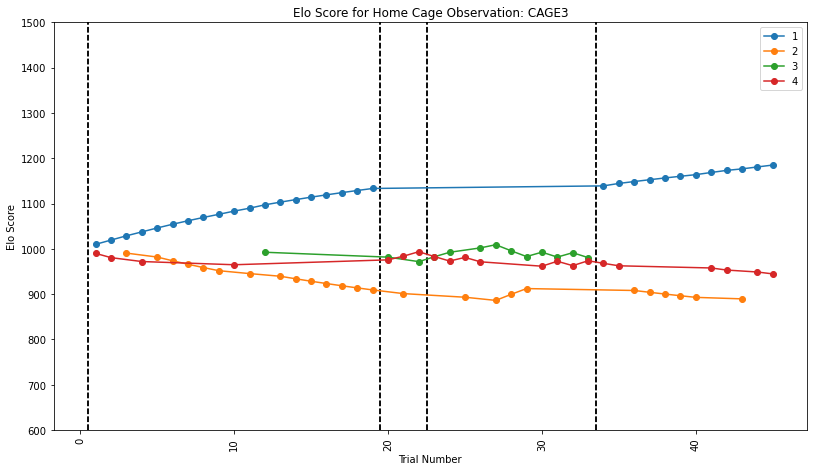

CAGE4


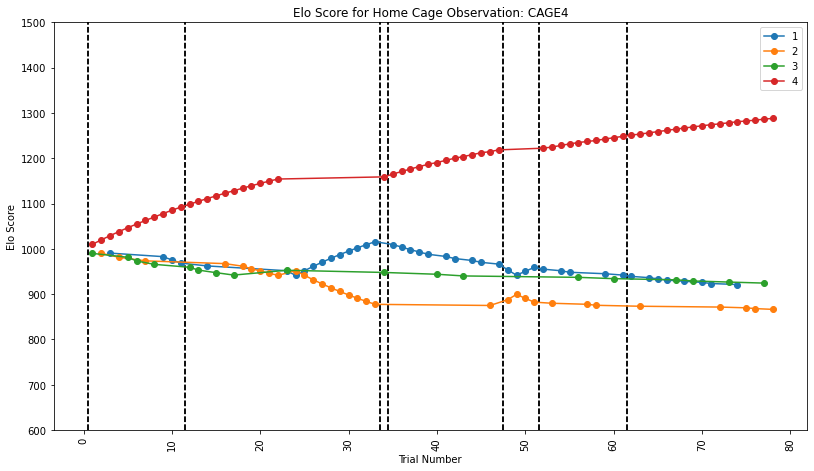

In [69]:
for key, value in sheet_to_data_frame.items():
    plt.rcParams["figure.figsize"] = (13.5,7.5)
    print(key)
    elo_score_data_frame = value["elo_score_data_frame"]
    fig, ax = plt.subplots()

    # Drawing vertical lines that represent when each session begins
    for index, row in elo_score_data_frame.dropna(subset=["session_number_plotting"]).iterrows():
        # Offsetting by 0.5 to avoid drawing the line on the dot
        plt.vlines(x=[row["total_match_number"] - 0.5], ymin=600, ymax=1500, colors='black', linestyle='dashed')

    # Drawing a line for each subject
    for subject in sorted(elo_score_data_frame["subject_id"].astype(str).unique()):
        # Getting all the rows with the current subject
        subject_df = elo_score_data_frame[elo_score_data_frame["subject_id"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        plt.plot(subject_df["total_match_number"], subject_df["updated_elo_score"], '-o', label=subject)

    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Trial Number")
    ax.set_ylabel("Elo Score")
    ax.set_title("Elo Score for Home Cage Observation: {}".format(key))
    # To show the legend
    ax.legend()
    plt.xticks(rotation=90)
    plt.ylim(600, 1500) 
    
    
    file_name = "home_cage_elo_score_{}_date_{}_{}.png".format(key, earliest_date, latest_date)
    plt.savefig(os.path.join(output_directory, file_name))
    
    plt.show()

# Saving the Dataframes

In [70]:
output_directory = "./proc/elo_score_spread_sheets/home_cage_observation_elo_score/cage_{}_date_{}_{}".format(all_cages, earliest_date, latest_date)

In [71]:
output_directory

'./proc/elo_score_spread_sheets/home_cage_observation_elo_score/cage_3_4_date_2022-05-04_2022-05-13'

In [72]:
os.makedirs(output_directory, exist_ok=True)

In [73]:
file_name = "home_cage_observation_elo_score_history_cages_{}_date_{}_{}.csv".format(all_cages, earliest_date, latest_date)
all_sheet_elo_scord_df_combined.to_csv(os.path.join(output_directory, file_name))

In [74]:
file_name = "home_cage_observation_final_elo_score_cages_{}_date_{}_{}.csv".format(all_cages, earliest_date, latest_date)
id_to_final_elo_score_df.to_csv(os.path.join(output_directory, file_name))